https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

In [1]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn                   # Graphics
import geopandas                 # Spatial data manipulation
import pandas                    # Tabular data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
import contextily                # Background tiles

In [2]:
ref = pandas.read_csv('brexit/brexit_vote.csv', 
                      index_col='Area_Code')

In [3]:
lads = geopandas.read_file("brexit/local_authority_districts.geojson")\
                .set_index('lad16cd')

In [4]:
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


In [5]:
lads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

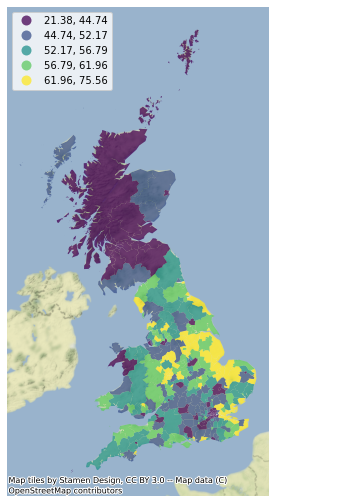

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='Pct_Leave', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )
ax.set_axis_off()

In [7]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

In [8]:
db['w_Pct_Leave'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

In [9]:
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()
db['w_Pct_Leave_std'] = ( db['w_Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()

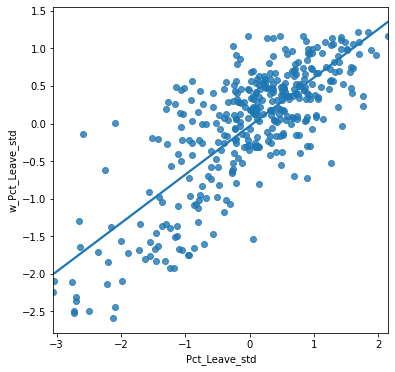

In [10]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Display
plt.show()

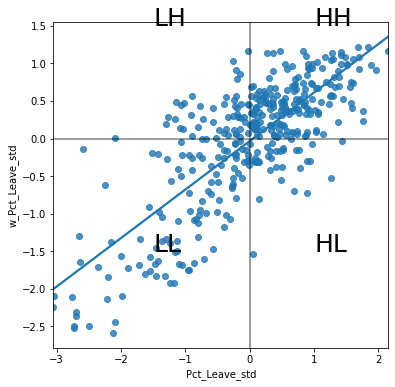

In [11]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [12]:
lisa = esda.moran.Moran_Local(db['Pct_Leave'], w)

<AxesSubplot:ylabel='Density'>

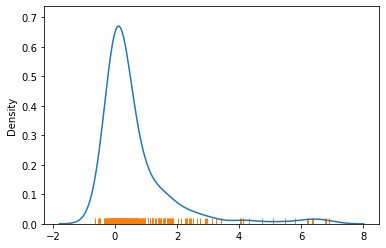

In [13]:
ax = seaborn.kdeplot(lisa.Is)
seaborn.rugplot(lisa.Is, ax=ax)

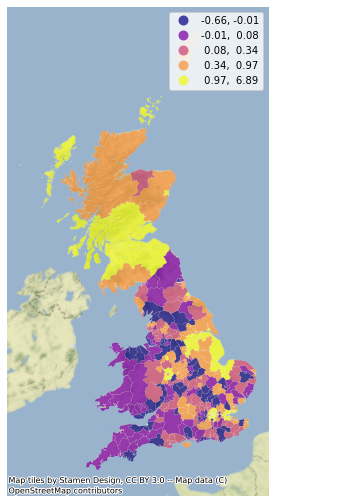

In [14]:
f, ax = plt.subplots(1, figsize=(9,9))
db['Is'] = lisa.Is
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [15]:
lisa.q

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1,
       1, 3, 4, 3, 4, 3, 3, 3, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 3, 3, 2, 2,
       1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 3, 2, 3, 4, 1, 3, 3, 3, 3, 2, 1,
       1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 4, 3, 1, 1, 1, 1, 2, 1,
       1, 1, 4, 1, 1, 1, 1, 3, 2, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 2, 1, 1,
       4, 3, 3, 3, 2, 4, 3, 3, 1, 2, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 2, 3,
       1, 1, 1, 1, 1, 1, 3, 2, 1, 4, 2, 1, 4, 1, 3, 1, 1, 1, 1, 1, 3, 2,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 1, 2, 3, 4, 1, 3, 1, 1, 3, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 4, 1,
       2, 1, 2, 4, 4, 2, 4, 3, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 3,
       1, 4, 2, 1, 2, 2, 2, 3, 1, 1, 1, 1, 2, 2, 3,

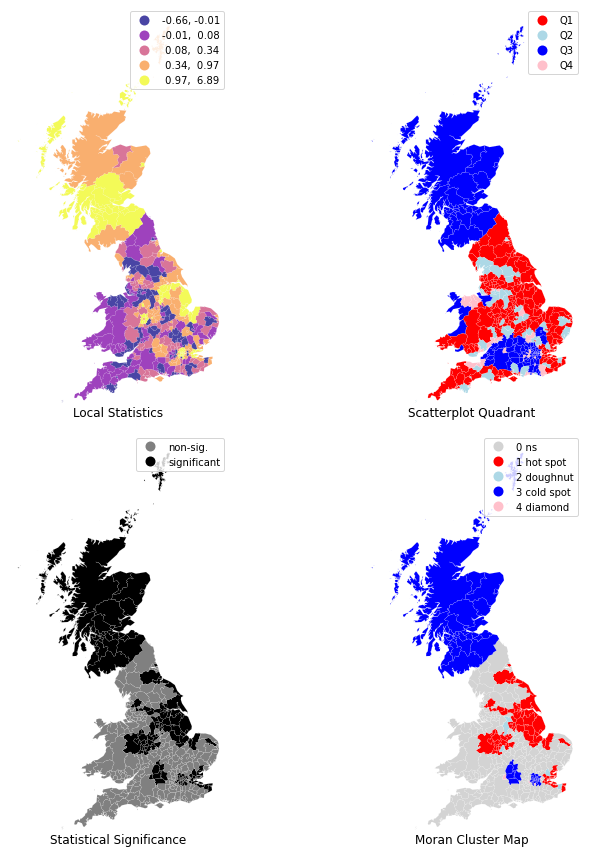

In [16]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])


db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Moran Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

In [17]:
counts = pandas.value_counts(lisa.q)
counts

1    183
3    113
2     50
4     34
dtype: int64

In [18]:
sig = 1 * (lisa.p_sim < 0.05)
db['p-sim'] = lisa.p_sim
db['sig'] = sig
db[['sig','p-sim']].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.014
E06000002,1,0.010
E06000003,1,0.016
E06000004,1,0.015
E06000010,1,0.019


In [19]:
db[['sig','p-sim']].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.497
W06000019,0,0.489
W06000021,0,0.479
W06000022,0,0.352
W06000023,0,0.280


In [20]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']

In [21]:
db['labels'] = labels
pandas.value_counts(labels)

0 ns           227
1 hot spot      73
3 cold spot     69
2 doughnut       7
4 diamond        4
dtype: int64

In [22]:
# Gi
gostats = esda.getisord.G_Local(db['Pct_Leave'], w)
# Gi*
gostars = esda.getisord.G_Local(db['Pct_Leave'], w, star=True)

In [23]:
def g_map(g, geog, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='lightgrey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(ax, 
                           crs=db.crs, 
                           source=contextily.providers.Stamen.TerrainBackground,

                          )
    st = ''
    if g.star:
        st = '*'
    ax.set_title(f'G{st} statistic for Pct of Leave votes', size=15)
    ax.set_axis_off()
    return ax

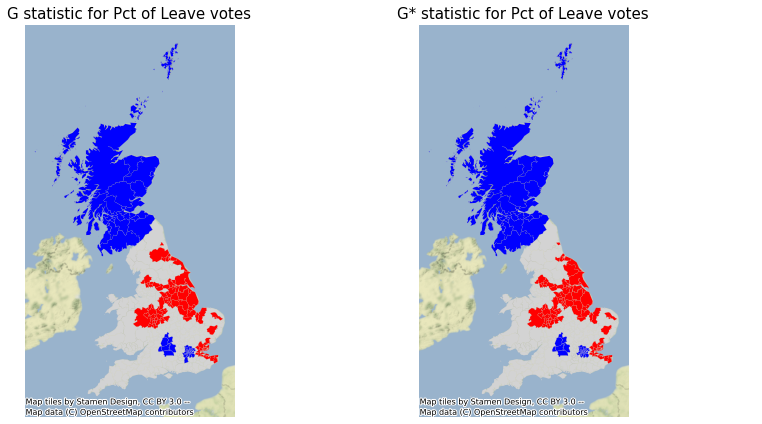

In [24]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics and generate the map
for g, ax in zip([gostats, gostars], axs.flatten()):
    ax = g_map(g, db, ax)
f.tight_layout()
# Render
plt.show()